In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from tqdm.autonotebook import tqdm
from joblib import Parallel, delayed
import umap
import pandas as pd

/mnt/cube/tsainbur/conda_envs/tpy3/lib/python3.6/site-packages/tqdm/autonotebook/__init__.py:14: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  " (e.g. in jupyter console)", TqdmExperimentalWarning)


In [3]:
from scipy.io import loadmat
from pathlib2 import Path

In [4]:
from vocalseg.utils import butter_bandpass_filter, spectrogram, int16tofloat32, plot_spec
from vocalseg.dynamic_thresholding import dynamic_threshold_segmentation

In [5]:
### parameters
n_fft=4096
hop_length_ms=1
win_length_ms=4
ref_level_db=20
pre=0.97
min_level_db=-70
silence_threshold = 0.01
min_silence_for_spec=0.1
max_vocal_for_spec=1.0,
min_syllable_length_s = 0.01
spectral_range = [50000, 100000]

In [6]:
from avgn.utils.paths import DATA_DIR, most_recent_subdirectory, ensure_dir

In [7]:
MATFILE = Path('/mnt/cube/Datasets/mouse_usv/FromGregg/sample_Bl6_breathing_data.mat')

In [8]:
voc_df = loadmat(MATFILE)
voc_df = pd.DataFrame(voc_df['breathing'][0])
voc_df['length_s'] = [np.max(row.time) for idx, row in voc_df.iterrows()]
voc_df

,mouse,genotype,age,time,pressure,audio,audioTime,fs,audioFS,length_s
0,[829],[C57Bl/6J],[P76],"[[1e-04, 0.0002, 0.0003, 0.0004, 0.0005, 0.000...","[[-0.062698364, -0.06253052, -0.062194824, -0....","[[0.0017700195], [0.0007324219], [-0.002227783...","[[-0.0017913372, -0.0017873376, -0.001783338, ...",[[10000]],[[250000]],204.633896
1,[832],[C57Bl/6J],[P76],"[[1e-04, 0.0002, 0.0003, 0.0004, 0.0005, 0.000...","[[-0.016738892, -0.016723633, -0.016830444, -0...","[[-0.00021362305], [0.0005493164], [0.00045776...","[[-0.0013908836, -0.001386884, -0.0013828843, ...",[[10000]],[[250000]],104.798103
2,[832],[C57Bl/6J],[P76],"[[1e-04, 0.0002, 0.0003, 0.0004, 0.0005, 0.000...","[[-0.01876831, -0.018966675, -0.019165039, -0....","[[0.00024414062], [-0.00012207031], [6.1035156...","[[-0.012664578, -0.012660579, -0.012656579, -0...",[[10000]],[[250000]],141.035095


In [9]:
row = voc_df.iloc[1]

In [10]:
rate = row.audioFS[0][0]
rate

250000

In [11]:
data = row.audio.flatten()
print(len(data)/rate)
#data = data[:int(20*rate)]

104.798096


In [12]:
data = butter_bandpass_filter(data, 500, 120000, rate)

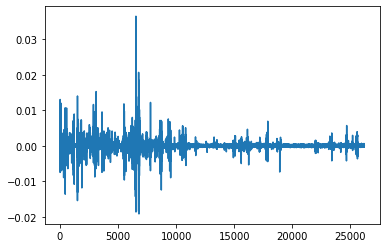

In [13]:
plt.plot(data[::1000])

In [14]:
spec = spectrogram(
    data,
    rate,
    n_fft=n_fft,
    hop_length_ms=hop_length_ms,
    win_length_ms=win_length_ms,
    ref_level_db=ref_level_db,
    pre=pre,
    min_level_db=min_level_db,
)
np.shape(spec)

(2049, 104799)

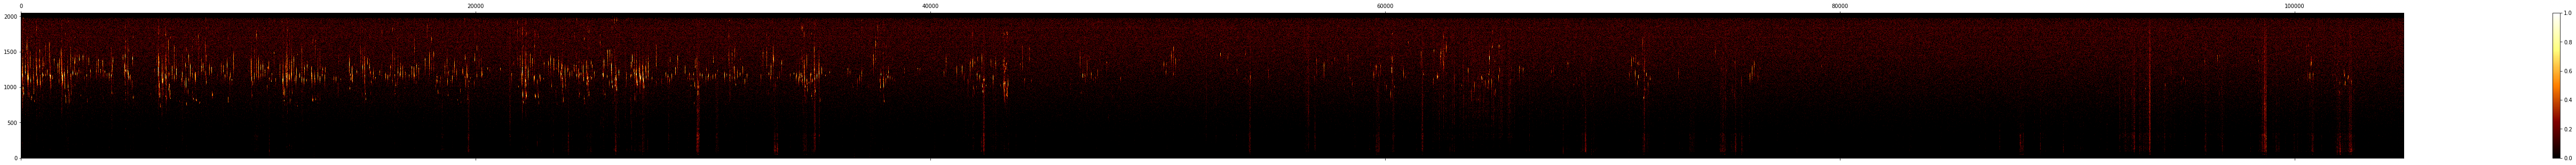

In [15]:
fig, ax = plt.subplots(figsize=(100,5))
plot_spec(spec, fig, ax);

In [16]:
results = dynamic_threshold_segmentation(
    data,
    rate,
    n_fft=n_fft,
    hop_length_ms=hop_length_ms,
    win_length_ms=win_length_ms,
    ref_level_db=ref_level_db,
    pre=pre,
    min_level_db=min_level_db,
    silence_threshold = silence_threshold,
    verbose=True,
    spectral_range = spectral_range,
    min_syllable_length_s = min_syllable_length_s
    
)

 17%|█▋        | 1/6 [00:02<00:13,  2.73s/it]

longest silence 0.0
longest vocalization 104.799
Current min_level_db: -70


 33%|███▎      | 2/6 [00:04<00:10,  2.53s/it]

longest silence 0.0
longest vocalization 104.799
Current min_level_db: -65


 50%|█████     | 3/6 [00:06<00:06,  2.28s/it]

longest silence 0.09899999999999665
longest vocalization 0.1769999999999996
Current min_level_db: -60


longest silence 13.432000000000002
longest vocalization 0.134999999999998


In [17]:
spec = results['spec']

In [18]:
from PIL import Image

In [121]:
spec_small = np.array(Image.fromarray(spec).resize((int(np.shape(spec)[1]/1), 32), Image.ANTIALIAS))

In [122]:
np.shape(spec), np.shape(spec_small)

((820, 104799), (32, 104799))

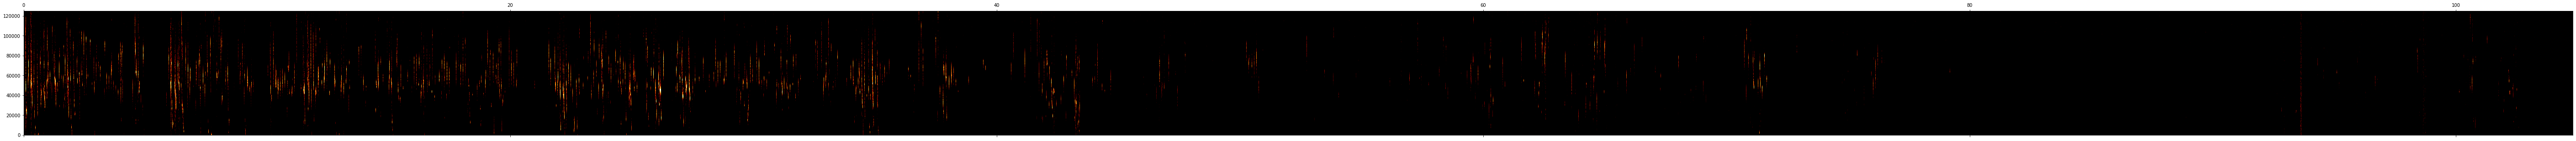

In [123]:
fig, ax = plt.subplots(figsize=(100,5))
plot_spec(spec, fig, ax, rate = rate, hop_len_ms= hop_length_ms, show_cbar=False);

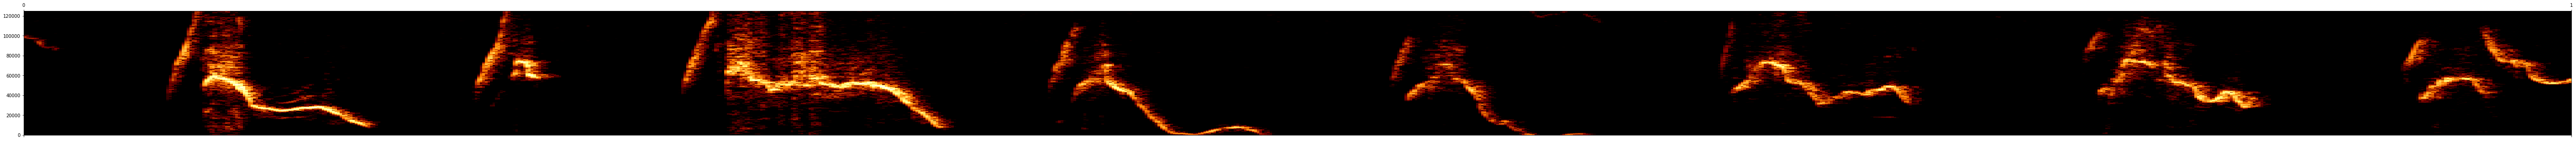

In [124]:
fig, ax = plt.subplots(figsize=(100,5))
plot_spec(spec[:,:1000], fig, ax, rate = rate, hop_len_ms= hop_length_ms, show_cbar=False);

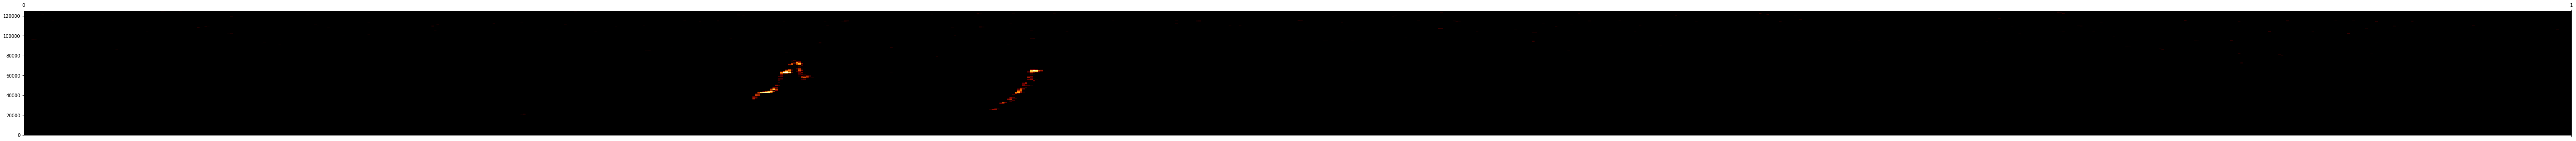

In [125]:
fig, ax = plt.subplots(figsize=(100,5))
plot_spec(spec[:,-10000:-9000], fig, ax, rate = rate, hop_len_ms= hop_length_ms, show_cbar=False);

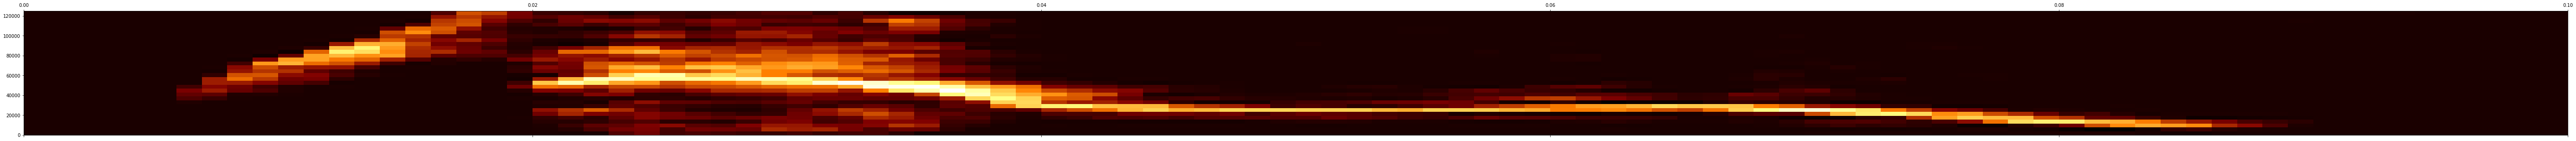

In [131]:
fig, ax = plt.subplots(figsize=(100,5))
plot_spec(spec_small[:,50:150], fig, ax, rate = rate, hop_len_ms= hop_length_ms, show_cbar=False);

### save windows

In [127]:
results.keys()

dict_keys(['spec', 'vocal_envelope', 'min_level_db', 'onsets', 'offsets'])

In [128]:
DATASET_ID = 'mouse_usv_long'

In [129]:
#row.mouse = [row.mouse[0] + '_1']

In [130]:
from avgn.utils.paths import DATA_DIR, most_recent_subdirectory, ensure_dir

In [104]:
ensure_dir(DATA_DIR/'umap_windows' / DATASET_ID)

In [138]:
from itertools import islice

def window(seq, n=2, skip = 100):
    "Returns a sliding window (of width n) over data from the iterable"
    "   s -> (s0,s1,...s[n-1]), (s1,s2,...,sn), ...                   "
    it = iter(seq)
    result = tuple(islice(it, n))
    if len(result) == n:
        yield result
    for elem in it:
        result = result[1:] + (elem,)
        yield result

In [139]:
for window_length_ms in tqdm([5]):
    window_length_frames = int(window_length_ms / hop_length_ms)
    windows = [i for i in window(spec_small.T, n =window_length_frames)]
    #windows = np.reshape(windows, (len(windows), np.product(np.shape(windows)[1:])))
    
    #save_loc = DATA_DIR/'umap_windows' / DATASET_ID / (row.mouse[0] + '_windows_' + str(window_length_ms))
    #np.save(save_loc.as_posix(), [list(i) for i in windows])

In [140]:
np.shape(spec_small), np.shape(windows)

((32, 104799), (104795, 5, 32))

In [232]:
window_start = 70
window_end = 100
nskip = 1

In [241]:
windows_list = np.arange(window_start, window_end-5, nskip)
windows_list

array([70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86,
       87, 88, 89, 90, 91, 92, 93, 94])

In [242]:
import matplotlib.patches as patches


In [243]:
import seaborn as sns

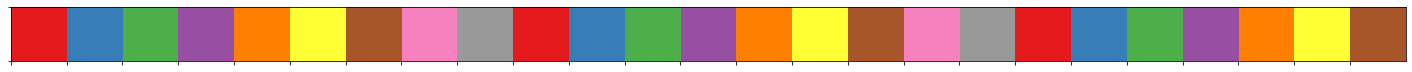

In [264]:
pal = sns.color_palette('Set1', len(windows_list))
sns.palplot(pal)

(-0.5, 29.5, -0.5, 31.5)

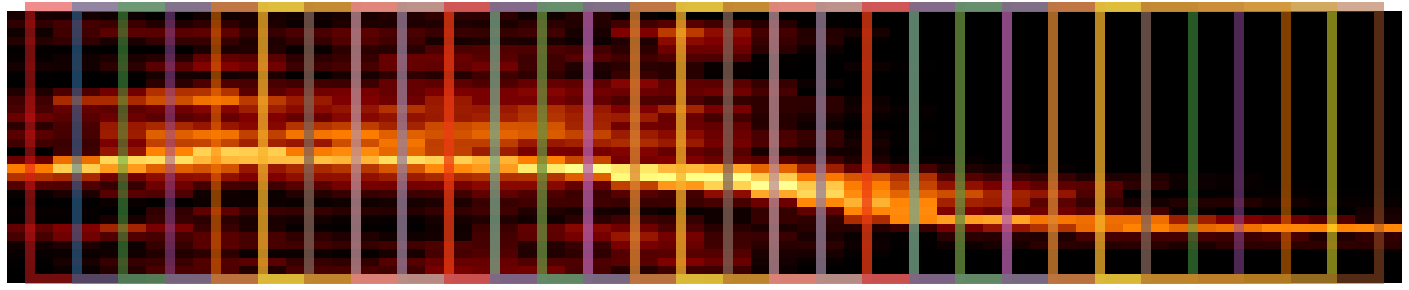

In [269]:
fig, ax = plt.subplots(figsize=(len(windows_list),5))
#plot_spec(spec_small[:,window_start:window_end], fig, ax, rate = rate, hop_len_ms= hop_length_ms, show_cbar=False);
ax.matshow(np.squeeze(spec_small[:,window_start:window_end]), aspect="auto", vmin=0, vmax=1, cmap = plt.cm.afmhot, origin='lower')#, extent=[0, len(windows_list), 0, 32])

for i, window in enumerate(windows_list):
    rect = patches.Rectangle((i,0),5,32,linewidth=10,edgecolor=pal[i],facecolor='none', clip_on=False, alpha = 0.5)
    # Add the patch to the Axes
    ax.add_patch(rect)
ax.axis('off')

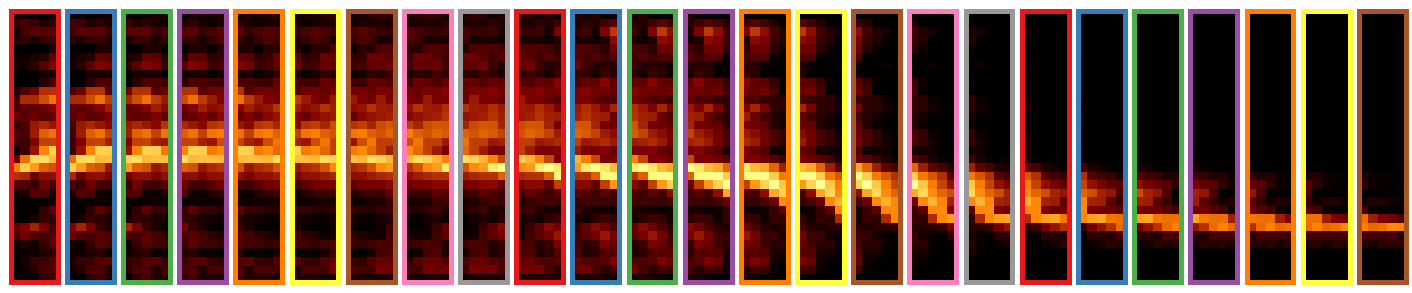

In [270]:
fig, axs = plt.subplots(ncols = len(windows_list), figsize=(len(windows_list),5))

for wi, window in enumerate(windows_list):
    ax = axs[wi]
    ax.matshow(np.array(windows[window]).T, aspect="auto", vmin=0, vmax=1, cmap = plt.cm.afmhot, origin='lower')
    #ax.axis('off')
    plt.setp(ax.spines.values(), color=pal[wi])
    [i.set_linewidth(5) for i in ax.spines.values()]
    ax.set_xticks([])
    ax.set_yticks([])

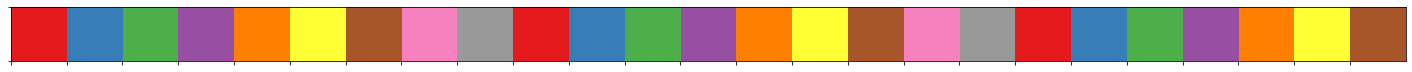

In [271]:
pal = sns.color_palette('Set1', len(windows_list))
sns.palplot(pal)

In [278]:
from avgn.utils.paths import FIGURE_DIR,ensure_dir
from avgn.utils.general import save_fig

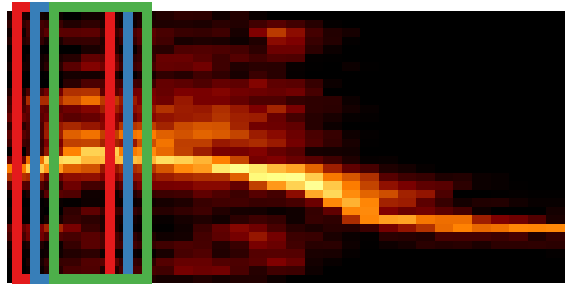

In [282]:
fig, ax = plt.subplots(figsize=(10,5))
#plot_spec(spec_small[:,window_start:window_end], fig, ax, rate = rate, hop_len_ms= hop_length_ms, show_cbar=False);
ax.matshow(np.squeeze(spec_small[:,window_start:window_end]), aspect="auto", vmin=0, vmax=1, cmap = plt.cm.afmhot, origin='lower')#, extent=[0, len(windows_list), 0, 32])

for i, window in enumerate(windows_list[:3]):
    rect = patches.Rectangle((i,0),5,32,linewidth=10,edgecolor=pal[i],facecolor='none', clip_on=False, alpha = 1)
    # Add the patch to the Axes
    ax.add_patch(rect)
ax.axis('off')
save_loc = FIGURE_DIR / "window_example" / 'windowing'
ensure_dir(save_loc)
save_fig(save_loc, save_pdf=True)

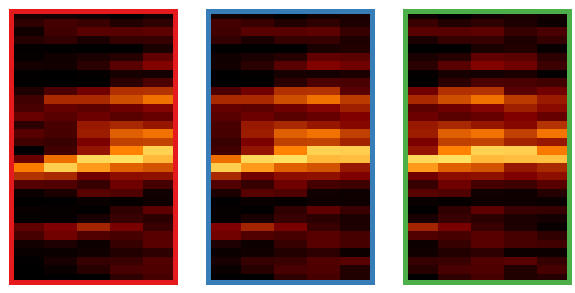

In [283]:
fig, axs = plt.subplots(ncols = 3, figsize=(10,5))

for wi, window in enumerate(windows_list[:3]):
    ax = axs[wi]
    ax.matshow(np.array(windows[window]).T, aspect="auto", vmin=0, vmax=1, cmap = plt.cm.afmhot, origin='lower')
    #ax.axis('off')
    plt.setp(ax.spines.values(), color=pal[wi])
    [i.set_linewidth(5) for i in ax.spines.values()]
    ax.set_xticks([])
    ax.set_yticks([])
    
save_loc = FIGURE_DIR / "window_example" / 'windows'
ensure_dir(save_loc)
save_fig(save_loc, save_pdf=True)

In [172]:
from cuml.manifold.umap import UMAP as cumlUMAP

In [173]:
cuml_umap = cumlUMAP(min_dist = 0.5)
embedding = cuml_umap.fit_transform(flat_windows)

In [175]:
np.shape(embedding)

(104795, 2)

In [176]:
embedding[:10]

array([[ 0.31787807,  4.68840456],
       [-0.00914308,  4.6967907 ],
       [-0.18384597,  4.87625456],
       [-0.1721745 ,  5.05819321],
       [-0.11976567,  5.00611687],
       [-0.00781844,  5.09484529],
       [ 0.06507917,  4.95554113],
       [-0.23895028,  4.6602335 ],
       [-0.45710561,  4.37310362],
       [-0.53151733,  4.26985216]])

(-15, 15)

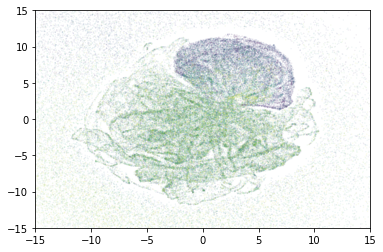

In [183]:
fig, ax = plt.subplots()
ax.scatter(embedding[:,0], embedding[:,1], s=0.1, alpha = 0.1, c=np.arange(len(embedding)))
ax.set_xlim([-15,15])
ax.set_ylim([-15,15])